In [1]:
from __future__ import print_function
from imutils import perspective
from scipy.spatial import distance as dist
import numpy as np
import cv2
import argparse
import imutils
import matplotlib.pyplot as plt
from imutils import contours
%matplotlib inline

In [2]:
def order_points(pts):
	# sort the points based on their x-coordinates
	xSorted = pts[np.argsort(pts[:, 0]), :]
 
	# grab the left-most and right-most points from the sorted
	# x-roodinate points
	leftMost = xSorted[:2, :]
	rightMost = xSorted[2:, :]
 
	# now, sort the left-most coordinates according to their
	# y-coordinates so we can grab the top-left and bottom-left
	# points, respectively
	leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
	(tl, bl) = leftMost
 
	# now that we have the top-left coordinate, use it as an
	# anchor to calculate the Euclidean distance between the
	# top-left and right-most points; by the Pythagorean
	# theorem, the point with the largest distance will be
	# our bottom-right point
	D = dist.cdist(tl[np.newaxis], rightMost, "euclidean")[0]
	(br, tr) = rightMost[np.argsort(D)[::-1], :]
 
	# return the coordinates in top-left, top-right,
	# bottom-right, and bottom-left order
	return np.array([tl, tr, br, bl], dtype="float32")


In [3]:
img=cv2.imread('size_1.jpeg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (7, 7), 0)
cv2.imshow('img',img)

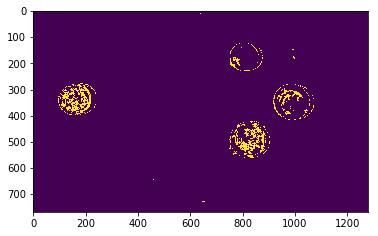

In [4]:
edged = cv2.Canny(img, 0, 100)
edged = cv2.dilate(edged, None, iterations=1)
edged = cv2.erode(edged, None, iterations=1)
plt.imshow(edged)

In [5]:
# find contours in the edge map
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if imutils.is_cv2() else cnts[1]
 
# sort the contours from left-to-right and initialize the
# 'pixels per metric' calibration variable
(cnts, _) = contours.sort_contours(cnts)
pixelsPerMetric = None

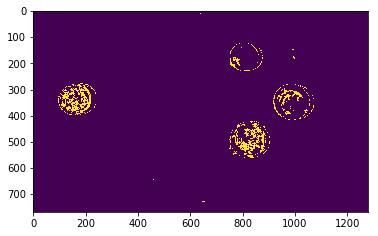

In [6]:
plt.imshow(edged)

In [7]:
def midpoint(ptA, ptB):
    return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)
# loop over the contours individually
for c in cnts:
    # if the contour is not sufficiently large, ignore it
    if cv2.contourArea(c) < 100:
        continue
 
    # compute the rotated bounding box of the contour
    orig = img.copy()
    box = cv2.minAreaRect(c)
    box = cv2.boxPoints(box)
    box = np.array(box, dtype="int")
    
    box = perspective.order_points(box)
    cv2.drawContours(orig, [box.astype("int")], -1, (0, 255, 0), 2)
    
    (tl, tr, br, bl) = box
    (tltrX, tltrY) = midpoint(tl, tr)
    (blbrX, blbrY) = midpoint(bl, br)

    # compute the midpoint between the top-left and top-right points,
    # followed by the midpoint between the top-righ and bottom-right
    (tlblX, tlblY) = midpoint(tl, bl)
    (trbrX, trbrY) = midpoint(tr, br)

    # draw the midpoints on the image
    cv2.circle(orig, (int(tltrX), int(tltrY)), 5, (255, 0, 0), -1)
    cv2.circle(orig, (int(blbrX), int(blbrY)), 5, (255, 0, 0), -1)
    cv2.circle(orig, (int(tlblX), int(tlblY)), 5, (255, 0, 0), -1)
    cv2.circle(orig, (int(trbrX), int(trbrY)), 5, (255, 0, 0), -1)

    # draw lines between the midpoints
    cv2.line(orig, (int(tltrX), int(tltrY)), (int(blbrX), int(blbrY)),(255, 0, 255), 2)
    cv2.line(orig, (int(tlblX), int(tlblY)), (int(trbrX), int(trbrY)),(255, 0, 255), 2)
    
    dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
    dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))
 
    # if the pixels per metric has not been initialized, then
    # compute it as the ratio of pixels to supplied metric
    # (in this case, inches)
    if pixelsPerMetric is None:
        pixelsPerMetric = dB /0.90
        
    # compute the size of the object
    dimA = dA / pixelsPerMetric
    dimB = dB / pixelsPerMetric
 
    # draw the object sizes on the image
    cv2.putText(orig, "{:.1f}in".format(dimA),(int(tltrX - 15), int(tltrY - 10)), cv2.FONT_HERSHEY_SIMPLEX,0.65, (255, 255, 255), 2)
    cv2.putText(orig, "{:.1f}in".format(dimB),(int(trbrX + 10), int(trbrY)), cv2.FONT_HERSHEY_SIMPLEX,0.65, (255, 255, 255), 2)
 
    # show the output image
    cv2.imshow("Image", orig)
    cv2.waitKey(0)
# cv2.waitKey(30)
# cv2.destroyAllWindows()